In [73]:
pip install mmcv-full

Note: you may need to restart the kernel to use updated packages.


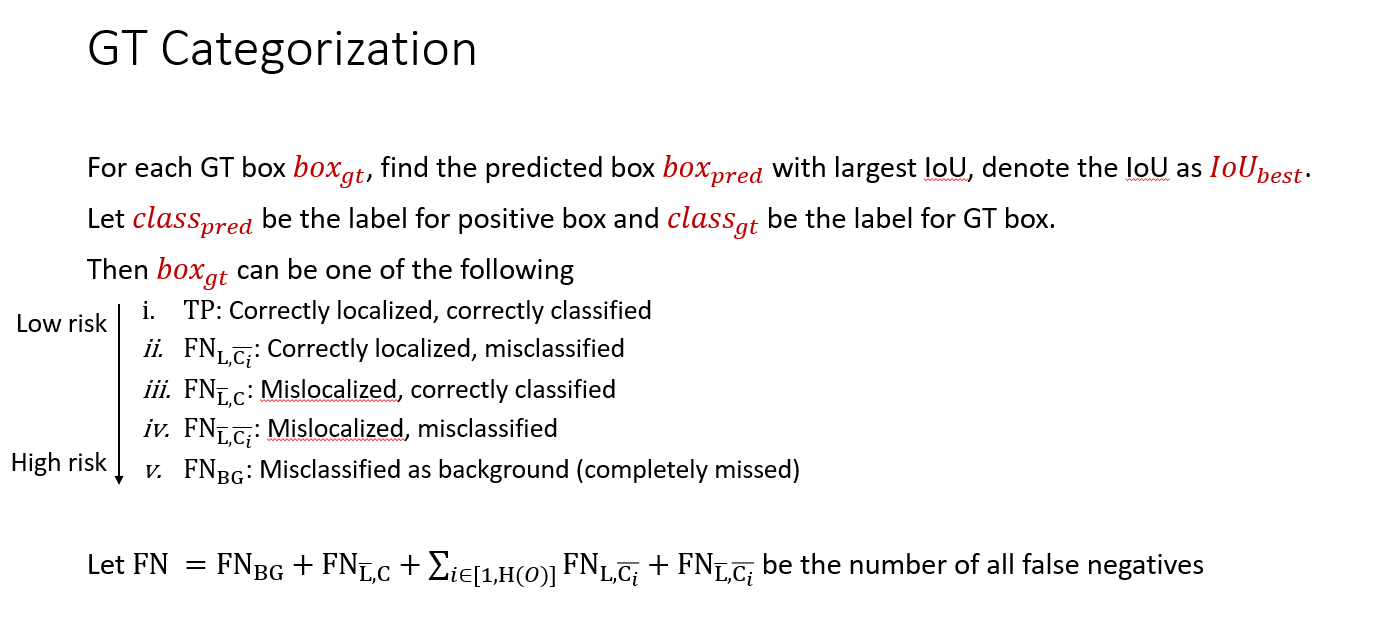

In [211]:
%load_ext autoreload
%autoreload 2

import os
from pprint import pprint

import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D

# New implementation
from detection_eval.detection_eval import DetectionEval
from detection_eval.filter import build_kitti_filters, ClassFilter, RangeFilter, CombinedFilter
from detection_eval.box_list import BoxList

print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/matthew/git/cadc_testing/uncertainty_eval


In [212]:
dataset_path = '/home/matthew/git/cadc_testing/WISEOpenLidarPerceptron/data/kitti'
logdir = '/home/matthew/git/cadc_testing/al_output/pcdet_log_20_epoch/kittidatasetvar/random/eval_192e0b82f64b5c2207934a583985aa2e'
gts_path = os.path.join(logdir, 'gt.pkl')

# Only one dict per frame
logdir = '/home/matthew/git/cadc_testing/WISEOpenLidarPerceptron/output/kitti_models/pointpillar_var/dropout_120_epochs_seed_11/eval/eval_with_train/epoch_40/val'
preds_path = os.path.join(logdir, 'ensemble_result.pkl')

# Clustering
logdir = '/home/matthew/git/cadc_testing/uncertainty_eval'
preds_path = os.path.join(logdir, 'result_converted.pkl')
gts_path = os.path.join(logdir, 'gts.pkl')

# Uncertainty Eval path to save the reliability diagram
uncertainty_eval_path='/home/matthew/git/cadc_testing/uncertainty_eval'

In [213]:
def load_dicts():
    # Load gt and prediction data dict
    with open(gts_path, 'rb') as f:
        gt_dicts = pickle.load(f)
    with open(preds_path, 'rb') as f:
        pred_dicts = pickle.load(f)
    return gt_dicts, pred_dicts

def load_image(frame_id):
    img_path = os.path.join(dataset_path, 'training', 'image_2', f'{frame_id}.png')
    return plt.imread(img_path)

def load_lidar(frame_id, xlim, ylim):
    lidar_path = os.path.join(dataset_path, 'training', 'velodyne', f'{frame_id}.bin')
    points = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)
    valid_mask = (points[:,0] > xlim[0]) & \
        (points[:,0] < xlim[1]) & \
        (points[:,1] > ylim[0]) & \
        (points[:,1] < ylim[1]) & \
        (points[:,2] < 4)
    points = points[valid_mask]
    return points

def add_box(ax, box, color=None):
    # box: [x, y, z, w, l, h, theta]
    w = box[3]
    h = box[4]
    xy = (box[0] - w/2, box[1] - h/2)
    angle = box[-1] * 180 / np.pi
    box_rect = Rectangle(
        xy, w, h, facecolor='none', edgecolor=color
    )
    t = Affine2D().rotate_around(box[0], box[1], box[-1]) + ax.transData
    box_rect.set_transform(t)
    ax.add_patch(box_rect)

In [215]:
# Load example GT and prediction
idx = np.random.randint(3700)
# idx = 2322, 291
idx = 0
print(idx)
gt_dicts, pred_dicts = load_dicts()

print('Example GT dict:')
print(gt_dicts[idx].keys())
print('Example pred dict:')
print(pred_dicts[idx][0].keys())

0
Example GT dict:
dict_keys(['gt_boxes', 'gt_labels', 'gt_names', 'frame_id'])
Example pred dict:
dict_keys(['name', 'truncated', 'occluded', 'alpha', 'bbox', 'dimensions', 'location', 'rotation_y', 'score', 'score_all', 'boxes_lidar', 'pred_labels', 'target_labels', 'pred_vars', 'pred_head_ids', 'frame_id'])


In [217]:
# Cluster pred_dicts
from cluster import cluster_preds

MIN_CLUSTER_SIZE = 3

print("Before clustering")
print("Number of frames", len(pred_dicts))
print("Number of pred dicts per frame", len(pred_dicts[0]))

pred_dicts = cluster_preds(pred_dicts, MIN_CLUSTER_SIZE)

print("After clustering")
print("Number of frames", len(pred_dicts))
print("Is the output per frame now a single dict?", isinstance(pred_dicts[0], dict))

Before clustering
Number of frames 3769
Number of pred dicts per frame 2
After clustering
Number of frames 3769
Is the output per frame now a single dict? True


In [218]:
print(pred_dicts[1])

{'frame_id': '000002', 'name': array([], dtype=float64), 'pred_labels': array([], dtype=float64), 'score': array([], dtype=float64), 'score_all': array([], dtype=float64), 'boxes_lidar': array([], dtype=float64), 'pred_vars': array([], dtype=float64)}


TypeError: string indices must be integers

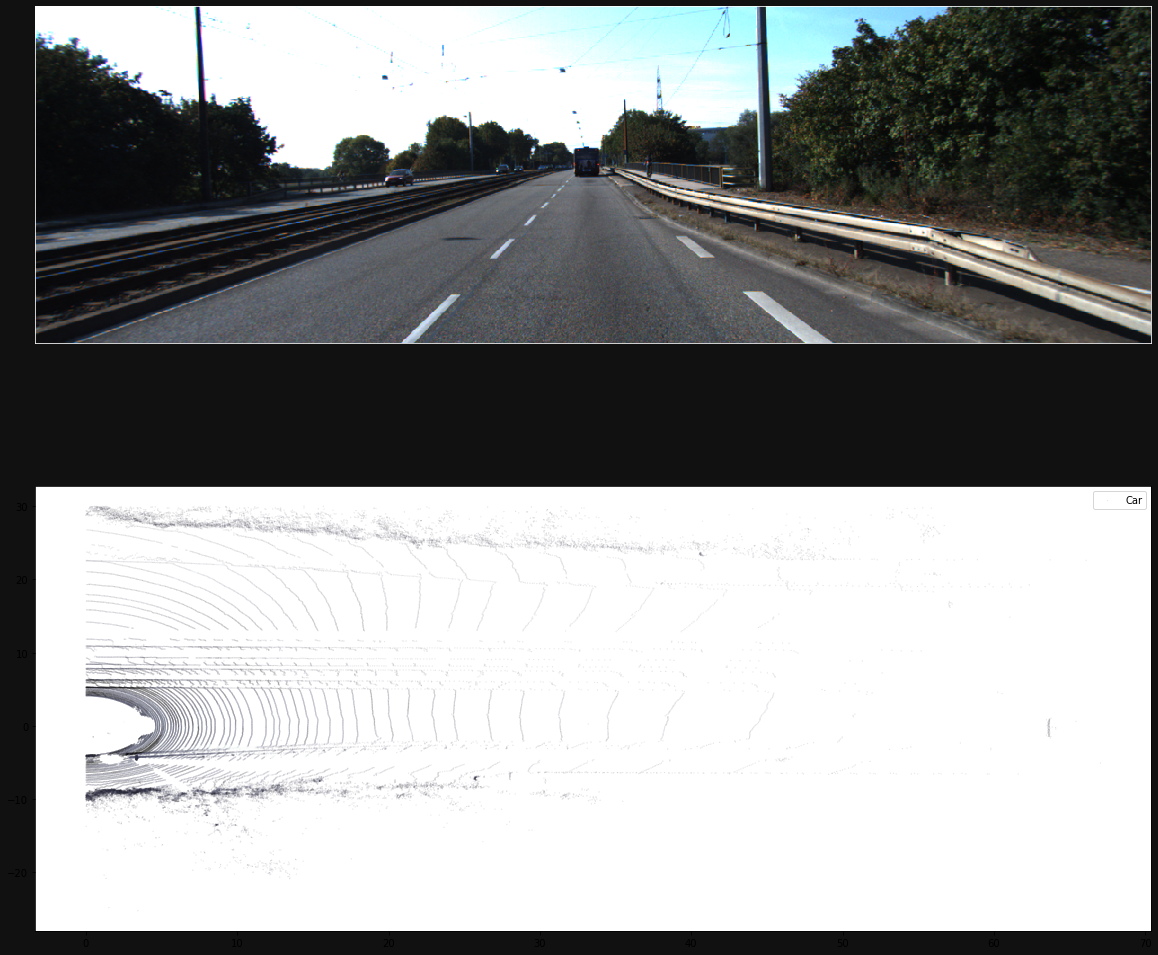

In [220]:
################################################################################
#
# Example: visualization
#
################################################################################

xlim = [0, 69.12]
ylim = [-30, 30]

gt_dict = gt_dicts[idx]
pred_dict = pred_dicts[idx]
points = load_lidar(gt_dict['frame_id'], xlim, ylim)
image = load_image(gt_dict['frame_id'])
scale = 0.32

plt.figure(figsize=(20, 18), facecolor=(0.067, 0.067, 0.067))

ax = plt.subplot(211)
plt.imshow(image)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax = plt.subplot(212)

ax.scatter(points[::-1,0], points[::-1,1], marker='.', s=0.01, c=points[:,3], cmap='bone')

ax.legend(('Car', 'Pedestrian', 'Cyclist'))

class_colors = ['tab:gray', 'tab:red', 'tab:orange', 'tab:pink', 'tab:gray']
# for label, box in zip(gt_dict['gt_labels'], gt_dict['gt_boxes']):
#     add_box(ax, box, color=class_colors[label])

class_colors = ['tab:gray', 'tab:blue', 'tab:cyan', 'tab:green', 'tab:gray']
# for label, box in zip(np.argmax(pred_dict['score_all'][:,:-1], axis=-1)+1, pred_dict['boxes_lidar']):
#     add_box(ax, box, color=class_colors[label])

# Display all pred_dicts for a frame
boxes = []
for single_pred_dict in pred_dict:
    for label, box in zip(np.argmax(single_pred_dict['score_all'][:,:-1], axis=-1)+1, single_pred_dict['boxes_lidar']):
        boxes.append(box)
        add_box(ax, box, color=class_colors[label])
        break
boxes = np.stack(boxes)
print(boxes.shape)
print(DetectionEval.compute_ctable(boxes.copy(), boxes.copy(), criterion='iou_3d'))

# Display first pred_dict in frame
# for label, box in zip(np.argmax(pred_dict[0][0]['score_all'][:,:-1], axis=-1)+1, pred_dict[0][0]['boxes_lidar']):
#     add_box(ax, box, color=class_colors[label])
# Display second pred_dict in frame
# for label, box in zip(np.argmax(pred_dict[1][0]['score_all'][:,:-1], axis=-1)+1, pred_dict[1][0]['boxes_lidar']):
#     add_box(ax, box, color=class_colors[label])

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_aspect(1)
ax.set_facecolor('black')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
for spine in ax.spines.values():
    spine.set_edgecolor('white')
    
plt.tight_layout()
plt.show()

In [188]:
def get_labels(data_dict):
    if 'gt_labels' in data_dict:
        return data_dict['gt_labels']
    if 'name' in data_dict:
        classes = ['Car', 'Pedestrian', 'Cyclist']
        return np.array([classes.index(name)+1 for name in data_dict['name']])
    raise ValueError()

def get_boxes(data_dict):
    if 'boxes_lidar' in data_dict:
        return data_dict['boxes_lidar']
    if 'gt_boxes' in data_dict:
        return data_dict['gt_boxes']
    raise ValueError()

def get_scores(data_dict):
    return data_dict['score']
    
def gt_processor(data_dict):
    return ( get_labels(data_dict), get_boxes(data_dict) )

def pred_processor(data_dict):
    return (get_labels(data_dict),
            get_scores(data_dict),
            get_boxes(data_dict))

def get_dist(data_dict):
    boxes = get_boxes(data_dict)
    coords = boxes[:,:2]
    dist = np.linalg.norm(coords, axis=1)
    return dist

In [189]:
################################################################################
# 
# Example: evaluating one sample
#
################################################################################

# Threshold (list or dict) maps a label to a matching threshold
# thresholds[label] = threshold
thresholds = {
    0: 0.5,    # Just to not output error
    1: 0.7,    # Car
    2: 0.5,    # Pedestrian
    3: 0.5     # Cyclist
}

# Examples for some common filters
# ClassFilter: filter by class, needs to specify class label
# RangeFilter: filter numerical value by a range
# CombinedFilter: combine multiple filters together with an `AND` clause

car_filter = ClassFilter(name='Car', label=1,
                         gt_processor=gt_processor, pred_processor=pred_processor)
ped_filter = ClassFilter(name='Pedestrian', label=2,
                         gt_processor=gt_processor, pred_processor=pred_processor)
cyc_filter = ClassFilter(name='Cyclist', label=3,
                         gt_processor=gt_processor, pred_processor=pred_processor)

dist_filter = RangeFilter(name='0-30m', value_range=(0, 30),
                          gt_processor=get_dist, pred_processor=get_dist)

ped_dist_filter = CombinedFilter([
    ped_filter, dist_filter
])

# Call `evaluate_one_sample` to get the results
gt_list, pred_list = DetectionEval.evaluate_one_sample(
    gt_dicts[idx],
    pred_dicts[idx],
    thresholds,
    criterion='iou',
    epsilon=0.1,
    filta=ped_filter,
    gt_processor=gt_processor,
    pred_processor=pred_processor
)

# The return values are two `BoxList` type object
# Each object contains the following fields
gt_list.keys()

['ignored',
 'bg',
 'localized',
 'loc_scores',
 'classified',
 'gt_labels',
 'pred_labels',
 'pred_scores',
 'matched_idx',
 'data']

In [190]:
# BoxList can be indexed in may ways
gt_list[ [0, 1, 5] ]    # Index by indices: get the items with index 0, 1 and 5
gt_list[ :5 ]           # Index by slices: get the first 5 items
gt_list[ ~gt_list.ignored ]           # Index by masks: get all true positives

# To access any field, you can do either
gt_list[0].localized
# or
gt_list.localized[0]

# The second one is for vectorized operations, since it returns a single binary mask
# It's the most efficient and should be used if possible
gt_list.localized & gt_list.classified

array([False, False, False, False, False, False, False])

In [191]:
# You can generate binary masks/filters for different categories easily

# TP is both localized and classified
tp = (~gt_list.ignored) & (gt_list.localized) & (gt_list.classified)
# Correctly localized, misclassified
l_mc = (~gt_list.ignored) & (gt_list.localized) & (~gt_list.classified)
# Mislocalized, correctly classified
ml_c = (~gt_list.ignored) & (~gt_list.localized) & (gt_list.classified)
# Mislocalized, misclassified
ml_mc = (~gt_list.ignored) & (~gt_list.localized) & (~gt_list.classified) & (~gt_list.bg)
# Completely missed
bg = (~gt_list.ignored) & (gt_list.bg)

In [192]:
################################################################################
#
# Example: evaluating multiple samples (e.g. validation set)
#
################################################################################

def attach_data(sample_idx, gt_dict, pred_dict, gt_list, pred_list):
    for i in range(len(gt_list)):
        gt_list.data[i] = dict(gt_boxes=gt_dict['gt_boxes'][i])
    for i in range(len(pred_list)):
        pred_list.data[i] = dict(
            score_all=pred_dict['score_all'][i],
            boxes_lidar=pred_dict['boxes_lidar'][i],
            pred_vars=pred_dict['pred_vars'][i]
        )

from tqdm.notebook import tqdm
gt_list, pred_list = DetectionEval.evaluate_all_samples(
    gt_dicts, pred_dicts,
    thresholds=thresholds,
    criterion='iou_3d',
    filta=car_filter,
    gt_processor=gt_processor,
    pred_processor=pred_processor,
    pbar=tqdm(total=len(gt_dicts)),
    callback=attach_data
)

# from tqdm import tqdm
# # Construct empty list to store the results
# gt_list = BoxList()
# pred_list = BoxList()

# # Loop through all dictionaries for each sample
# for gt_dict, pred_dict in tqdm(zip(gt_dicts, pred_dicts), total=len(gt_dicts)):
#     # Get results for one sample
# #     print(pred_processor(pred_dict))
#     gt_list_one, pred_list_one = DetectionEval.evaluate_one_sample(
#         gt_dict,
#         pred_dict,
#         thresholds,
#         criterion='iou',
#         epsilon=0.1,
#         filta=car_filter,
#         gt_processor=gt_processor,
#         pred_processor=pred_processor
#     )

#     # Attach any extra data you need, e.g. frame_id, box coordinates, etc.
#     # The data field needs to be an np array of dictinary/objects of the same size as other fields
#     # i.e.  1) len( list.data ) = number of gt boxes
#     #       2) list.data[i] = object or dict
# #     gt_list_one.data = np.array([gt_dict] * len(get_labels(gt_dict)), dtype=object)
# #     gt_list_one.data = [gt_dict] * len(get_labels(gt_dict))
#     for i in range(len(gt_dict['gt_boxes'])):
#         gt_list_one.data[i] = {
#             'gt_boxes': gt_dict['gt_boxes'][i]
#         }
# #     pred_list_one.data = np.array([pred_dict] * len(get_labels(pred_dict)), dtype=object)
#     # Add scores, box coordinates and box variances
#     for i in range(len(pred_dict['score_all'])):
#         pred_list_one.data[i] = {
#             'score_all': pred_dict['score_all'][i],
#             'boxes_lidar': pred_dict['boxes_lidar'][i],
#             'pred_vars': pred_dict['pred_vars'][i]
#         }

#     # Aggregate the results by simple addition
#     gt_list += gt_list_one
#     pred_list += pred_list_one

In [193]:
# TP is both localized and classified
tp = (~gt_list.ignored) & (gt_list.localized) & (gt_list.classified)
# Correctly localized, misclassified
l_mc = (~gt_list.ignored) & (gt_list.localized) & (~gt_list.classified)
# Mislocalized, correctly classified
ml_c = (~gt_list.ignored) & (~gt_list.localized) & (gt_list.classified)
# Mislocalized, misclassified
ml_mc = (~gt_list.ignored) & (~gt_list.localized) & (~gt_list.classified) & (~gt_list.bg)
# Completely missed
bg = (~gt_list.ignored) & (gt_list.bg)

In [194]:
# Some FN statistics
from collections import OrderedDict
pprint(OrderedDict(
    total=(~gt_list.ignored).sum(),
    true_positive=tp.sum(),
    localized_misclassified=l_mc.sum(),
    mislocalized_classified=ml_c.sum(),
    mislocalized_misclassified=ml_mc.sum(),
    completely_missed=bg.sum()
))

OrderedDict([('total', 14385),
             ('true_positive', 10318),
             ('localized_misclassified', 0),
             ('mislocalized_classified', 3586),
             ('mislocalized_misclassified', 8),
             ('completely_missed', 473)])


In [14]:
# Get a few completely missed objects
gt_list[bg][:5]

[{'ignored': False, 'bg': True, 'localized': False, 'loc_score': -inf, 'classified': False, 'gt_label': 1, 'pred_label': -1, 'pred_score': nan, 'matched_idx': -1},
 {'ignored': False, 'bg': True, 'localized': False, 'loc_score': 0.0, 'classified': False, 'gt_label': 1, 'pred_label': -1, 'pred_score': nan, 'matched_idx': -1},
 {'ignored': False, 'bg': True, 'localized': False, 'loc_score': 0.0, 'classified': False, 'gt_label': 1, 'pred_label': -1, 'pred_score': nan, 'matched_idx': -1},
 {'ignored': False, 'bg': True, 'localized': False, 'loc_score': 0.0, 'classified': False, 'gt_label': 1, 'pred_label': -1, 'pred_score': nan, 'matched_idx': -1},
 {'ignored': False, 'bg': True, 'localized': False, 'loc_score': 0.0, 'classified': False, 'gt_label': 1, 'pred_label': -1, 'pred_score': nan, 'matched_idx': -1}]

In [45]:
# Get their frame_id for plotting etc.
list([gt_info.data['frame_id'] for gt_info in gt_list[bg][:5]])

KeyError: 'frame_id'

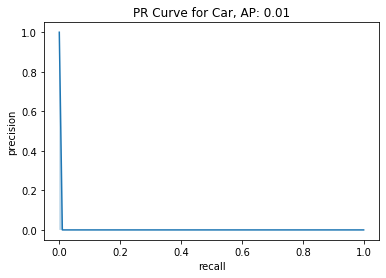

In [46]:
# You can directly compute normal AP metrics, and plot PR curve, using the gt_list and pred_list
stats = DetectionEval.compute_statistics(gt_list, pred_list)

plt.figure()
plt.plot(stats['rec'], stats['prec'])
plt.fill_between(stats['rec'], stats['prec'], alpha=0.3)
plt.title(f'PR Curve for Car, AP: {stats["ap"]:.2f}')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [47]:
np.unique(gt_list[ml_mc].pred_labels, return_counts=True)

(array([2, 3]), array([4, 4]))

In [195]:
# A prediction box is either a TP or FP

# TP is both localized and classified
tp = (~pred_list.ignored) & (pred_list.localized) & (pred_list.classified)
# FP is the negative of TPs
fp = (~tp)

print(pred_list[tp][0])
print(pred_list[tp][0].data)

{'ignored': False, 'bg': False, 'localized': True, 'loc_score': 0.7022631168365479, 'classified': True, 'gt_label': 1, 'pred_label': 1, 'pred_score': 0.630692720413208, 'matched_idx': 1}
{'score_all': array([6.3069272e-01, 5.8715215e-09, 5.8346368e-09, 3.6930728e-01],
      dtype=float32), 'boxes_lidar': array([58.761223 , 16.507935 , -1.4677916,  4.1079082,  1.6377232,
        1.4544902,  3.0958695], dtype=float32), 'pred_vars': array([1.       , 1.       , 1.       , 1.0000002, 1.0000023, 1.       ,
       1.       ], dtype=float32)}


In [203]:
print("match pred 0 to gt 0")
print(pred_list[tp][0])
print(pred_list[tp][0].data['boxes_lidar'])
print(gt_list[1])
print(gt_list[1].data)
print(pred_list[0])
print(pred_list[0].data['boxes_lidar'])

print("match pred 10 to gt 4")
print(pred_list[tp][10])
print(pred_list[tp][10].data['boxes_lidar'])
print(gt_list[37])
print(gt_list[37].data)
print(pred_list[120])
print(pred_list[120].data['boxes_lidar'])

match pred 0 to gt 0
{'ignored': False, 'bg': False, 'localized': True, 'loc_score': 0.7022631168365479, 'classified': True, 'gt_label': 1, 'pred_label': 1, 'pred_score': 0.630692720413208, 'matched_idx': 1}
[58.761223  16.507935  -1.4677916  4.1079082  1.6377232  1.4544902
  3.0958695]
{'ignored': False, 'bg': False, 'localized': True, 'loc_score': 0.7022631168365479, 'classified': True, 'gt_label': 1, 'pred_label': 1, 'pred_score': 0.630692720413208, 'matched_idx': 0}
{'gt_boxes': array([58.780804 , 16.559635 , -1.6761109,  3.69     ,  1.87     ,
        1.67     , -3.1407964], dtype=float32)}
{'ignored': False, 'bg': False, 'localized': True, 'loc_score': 0.7022631168365479, 'classified': True, 'gt_label': 1, 'pred_label': 1, 'pred_score': 0.630692720413208, 'matched_idx': 1}
[58.761223  16.507935  -1.4677916  4.1079082  1.6377232  1.4544902
  3.0958695]
match pred 10 to gt 4
{'ignored': False, 'bg': False, 'localized': True, 'loc_score': 0.8042876124382019, 'classified': True, 'gt_

In [204]:
print("match pred 0 to gt 0")
print(pred_list[0])
print(pred_list[0].data['boxes_lidar'])
print(gt_list[0])
print(gt_list[0].data)

print(pred_list[7])
print(pred_list[7].data['boxes_lidar'])
print(gt_list[0])
print(gt_list[0].data)

match pred 0 to gt 0
{'ignored': False, 'bg': False, 'localized': True, 'loc_score': 0.7022631168365479, 'classified': True, 'gt_label': 1, 'pred_label': 1, 'pred_score': 0.630692720413208, 'matched_idx': 1}
[58.761223  16.507935  -1.4677916  4.1079082  1.6377232  1.4544902
  3.0958695]
{'ignored': True, 'bg': False, 'localized': False, 'loc_score': nan, 'classified': False, 'gt_label': -1, 'pred_label': -1, 'pred_score': nan, 'matched_idx': -1}
{'gt_boxes': array([ 6.9724792e+01, -4.4756469e-01, -8.4134758e-01,  1.2340000e+01,
        2.6300001e+00,  2.8499999e+00, -1.0796428e-02], dtype=float32)}
{'ignored': False, 'bg': False, 'localized': False, 'loc_score': 0.6519565582275391, 'classified': True, 'gt_label': 1, 'pred_label': 1, 'pred_score': 0.8607274889945984, 'matched_idx': 6}
[34.79447   -3.1521869 -2.2436996  4.029151   1.6086378  1.4223595
  6.334115 ]
{'ignored': True, 'bg': False, 'localized': False, 'loc_score': nan, 'classified': False, 'gt_label': -1, 'pred_label': -1, '

tp_dontcare_count 0
fp_dontcare_count 0
Accuracy bins [0.         0.00145885 0.00979582 0.02680784 0.07609088 0.16285211
 0.26860084 0.43818943 0.67778074 0.89939811]
Calculated ECE 0.20279849147167234
NLL Classification mean 0.3710960229608791
Binary Brier Score Classification mean 0.10798882359157774
Brier Score Classification mean 0.09168630932950214
cls_expected_calibration_error 0.06534432160440545
cls_expected_calibration_error 'stable binning' 0.06533987143174239
cls_marginal_calibration_error 0.12440938302692946


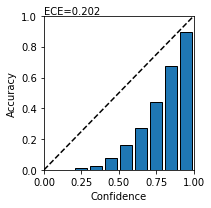

In [210]:
from nll_clf import NLLCLF
from nll_reg import NLLREG
from binary_brier_score import BINARYBRIERSCORE
from brier_score import BRIERSCORE
from dmm import DMM

# Calibration Error
from ece import calculate_ece, plot_reliability
import calibration as cal

NUM_CLASSES = 3

# Scoring Rules
nll_clf_obj = NLLCLF()
nll_reg_obj = NLLREG()
binary_brier_obj = BINARYBRIERSCORE()
brier_obj = BRIERSCORE()
dmm_obj = DMM()

# Our own ECE Implementation
num_bins = 10
bins = np.arange(0, 1+1/num_bins, 1/num_bins)
conf_mat = [{'TP': 0, 'FP': 0} for i in range(len(bins))]

# Calibration library lists
preds_score_all = []
gt_score_all = []

# Keep track of odd TPs/FPs
tp_dontcare_count = 0
fp_dontcare_count = 0

# TP loop Scoring Rules
for obj in pred_list[tp]:
    gt_box = gt_list[int(obj.matched_idx)].data['gt_boxes']
    nll_clf_obj.add_tp(obj.pred_score)
#     nll_reg_obj.add_tp(gt_box, obj.data['boxes_lidar'], obj.data['pred_vars'])
    binary_brier_obj.add_tp(obj.pred_score)
    brier_obj.add_tp(obj.pred_label, obj.data['score_all'])
#     dmm_obj.add_tp(gt_box, obj.data['boxes_lidar'], obj.data['pred_vars'])

# FP loop Scoring Rules
for obj in pred_list[fp]:
    nll_clf_obj.add_fp(obj.pred_score)
    binary_brier_obj.add_fp(obj.pred_score)

# TP loop Calibration Error
for obj in pred_list[tp]:
    bin_num = np.ceil(obj.pred_score * num_bins).astype(int)
    conf_mat[bin_num]['TP'] += 1
    # Calibration library
    preds_score_all.append(obj.data['score_all'][0])
    preds_score_all.append(obj.data['score_all'][1])
    preds_score_all.append(obj.data['score_all'][2])
    # add one hot to GT
    gt_label = obj.gt_label
    for one_hot in range(NUM_CLASSES):
        if one_hot == int(gt_label - 1):
            gt_score_all.append(1)
        else:
            gt_score_all.append(0)

    # These check for strange output
#     if pred['target_labels'][idx] == -1:
#         tp_dontcare_count += 1
#     if pred['target_labels'][idx] != pred['pred_labels'][idx]:
#         print('WOAH target label != pred label')
#         print(pred['target_labels'][idx])
#         print(pred['pred_labels'][idx])

# FP loop Calibration Error
for obj in pred_list[fp]:
    bin_num = np.ceil(obj.pred_score * num_bins).astype(int)
    conf_mat[bin_num]['FP'] += 1
    nll_clf_obj.add_fp(obj.pred_score)
    binary_brier_obj.add_fp(obj.pred_score)
    # Calibration library
    preds_score_all.append(obj.data['score_all'][0])
    preds_score_all.append(obj.data['score_all'][1])
    preds_score_all.append(obj.data['score_all'][2])
    gt_score_all.append(0)
    gt_score_all.append(0)
    gt_score_all.append(0)

    # These check for strange output
#     if pred['target_labels'][idx] == -1:
#         print("FP with target label Don't Care")
#         print(ret)
#         fp_dontcare_count += 1
#     elif pred['target_labels'][idx] == 0:
#         print("FP with target label BG")
#     else:
#         print("Interesting case FP with not BG target label")

accuracy, ece, key = calculate_ece(conf_mat, num_bins, car_filter.name)

print('tp_dontcare_count', tp_dontcare_count)
print('fp_dontcare_count', fp_dontcare_count)
print("Accuracy bins", accuracy)
print("Calculated ECE", ece)


plot_reliability(accuracy, ece, save_path=uncertainty_eval_path+'/ECE_'+key+'.png')

print('NLL Classification mean', nll_clf_obj.mean())
# print('NLL Regression mean', nll_reg_obj.mean())
print('Binary Brier Score Classification mean', binary_brier_obj.mean())
print('Brier Score Classification mean', brier_obj.mean())
# print('DMM Regression mean', dmm_obj.mean())

# ECE
cls_expected_calibration_error = cal.get_ece(
    preds_score_all, gt_score_all)
print("cls_expected_calibration_error", cls_expected_calibration_error)
# ECE stable binning (seems the same)
cls_expected_calibration_error = cal.get_top_calibration_error(
    preds_score_all, gt_score_all, p=1)
print("cls_expected_calibration_error 'stable binning'", cls_expected_calibration_error)
# Marginal CE
cls_marginal_calibration_error = cal.get_calibration_error(
    preds_score_all, gt_score_all)
print("cls_marginal_calibration_error", cls_marginal_calibration_error)
